In [1]:
# 필요한 model을 import한다

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

In [2]:
# 본 모델의 학습과 성능평가를 위해 STL10 Dataset을 사용할 예정이다

# STL Dataset을 다운로드 받을 Directory를 지정한다
path2data = './data'

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
train_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

print(len(train_ds))
print(len(val_ds))

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
5000
8000


In [3]:
# DataLoader에 사용될 Pre-Processor를 정의한다
transformation = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(224)
])

train_ds.transform = transformation
val_ds.transform = transformation

# Train dataset, Validation dataset의 Dataloader 생성
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

In [4]:
from torch.nn.modules.batchnorm import BatchNorm2d
# MobileNet에 사용되는 여러 module에 대한 정의를 해보자
# MobileNet의 Depthwise Separable Convolution 계층을 정의한다
# Depthwise Separable Convolution layer는
# Depthwise conv + Pointwise conv으로 구성되어있다.
# Depthwise conv는 각 channel별로 3x3 convlayer에 통과시켜 나중에 concat하며
# Pointwise conv는 위에서 concat된 feature map을 1x1 conv를 통과시켜 채널을 감소시키는 역할을 한다

class Depthwise(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()

    # Depthwise Convolution 정의
    self.depthwise = nn.Sequential(
        # groups parameter가 in_channels이면 입력 데이터의 각 channel이 하나의 kernel과 연산되어 각각 그 결과가 반환되고
        # 최종적으로 그 결과들이 concatenate되어 최종 값으로 반환된다
        nn.Conv2d(in_channels, in_channels, 3, stride=stride, padding=1, groups=in_channels, bias=False),
        nn.BatchNorm2d(in_channels),
        # ReLU6 : ReLU함수의 상한값을 6으로 설정한 비선형 함수이다. 연산량을 줄이고 정확도가 높아지는 장점이 있다
        # MobileNet에서 주로 사용되는 활성화 함수이다
        nn.ReLU6()
    )

    # Pointwise Conv : 1x1 conv연산을 수행하여 채널을 감소시키는 역할을 한다
    self.pointwise = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU6()
    )

  def forward(self, x):
    x = self.depthwise(x)
    x = self.pointwise(x)
    return x

# Convoluation layer에 Batchnormalization과 ReLU를 일괄적으로 적용한 객체를 한번에 생성하기 위해 정의함
class BasicConv2d(nn.Module):
  def __init__(self, in_Channels, out_channels, kernel_size, **kwargs):
    super().__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(in_Channels, out_channels, kernel_size, **kwargs),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

  def forward(self, x):
    x = self.conv(x)
    return x

# 본격적으로 MobileNet을 구성해보도록 하자
# MobileNet에는 Width_multiplier라는 Hyper Parameter가 존재한다
# Convolutional layer에서 width란 channel을 의미하며
# 0~1사이의 값을 가지는 해당 파라미터에 의하여 각 Layer에서의 feature map 출력 channel이 조정된다

class MobileNet(nn.Module):
  def __init__(self, width_multiplier, num_classes=10, init_weights=True):
    super().__init__()
    self.init_weights = init_weights
    alpha = width_multiplier

    self.conv1 = BasicConv2d(3, int(32*alpha), 3, stride=2, padding=1)
    self.conv2 = Depthwise(int(32*alpha), int(64*alpha), stride=1)
    
    # Down Sample : 형상을 줄어들고 채널은 증가한다
    self.conv3 = nn.Sequential(
        Depthwise(int(64*alpha), int(128*alpha), stride=2),
        Depthwise(int(128*alpha), int(128*alpha), stride=1)
    )

    # Down Sample : 형상을 줄어들고 채널은 증가한다
    self.conv4 = nn.Sequential(
        Depthwise(int(128*alpha), int(256*alpha), stride=2),
        Depthwise(int(256*alpha), int(256*alpha), stride=1)
    )

    # Down Sample : 형상을 줄어들고 채널은 증가한다
    self.conv5 = nn.Sequential(
        Depthwise(int(256*alpha), int(512*alpha), stride=2),
        Depthwise(int(512*alpha), int(512*alpha), stride=1),
        Depthwise(int(512*alpha), int(512*alpha), stride=1),
        Depthwise(int(512*alpha), int(512*alpha), stride=1),
        Depthwise(int(512*alpha), int(512*alpha), stride=1),
        Depthwise(int(512*alpha), int(512*alpha), stride=1),
    )


    # Down Sample : 형상을 줄어들고 채널은 증가한다
    self.conv6 = nn.Sequential(
        Depthwise(int(512*alpha), int(1024*alpha), stride=2)
    )

    # Down Sample : 형상을 줄어든다
    self.conv7 = nn.Sequential(
        Depthwise(int(1024*alpha), int(1024*alpha), stride=2)
    )

    self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
    self.linear = nn.Linear(int(1024*alpha), num_classes)

    if self.init_weights:
      self._initialize_weights()

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.conv6(x)
    x = self.conv7(x)
    x = self.avg_pool(x)
    x = x.view(x.size(0),-1)
    x = self.linear(x)
    return x

  def _initialize_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0) 

   
# MobileNet을 생성하는 함수 제작
def mobilenet(alpha=1, num_classes=10):
  return MobileNet(alpha, num_classes)

In [5]:
# 모델을 설계 완료하였으니 input과 output을 Test해보자
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.randn((3,3,224,224)).to(device)
model = mobilenet(alpha=1).to(device)
output = model(x)
print("output size : ", output.size())

output size :  torch.Size([3, 10])


In [6]:
# model에 특정 input을 입력했을 때의 각 단계에서의 출력값
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
       BasicConv2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]             288
       BatchNorm2d-6         [-1, 32, 112, 112]              64
             ReLU6-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]           2,048
       BatchNorm2d-9         [-1, 64, 112, 112]             128
            ReLU6-10         [-1, 64, 112, 112]               0
        Depthwise-11         [-1, 64, 112, 112]               0
           Conv2d-12           [-1, 64, 56, 56]             576
      BatchNorm2d-13           [-1, 64, 56, 56]             128
            ReLU6-14           [-1, 64,

In [7]:
# 본격적으로 학습을 위한 함수를 제작하자
# 하나의 batch_set의 데이터들의 손실함수가 모두 합산되어 반환되도록 정의
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
# 30회마다 Learning rate를 10분의 1로 줄여주는 Scheduler 제작
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

# optimizer의 현재 Learning rate를 반환하는 함수 제작
def get_lr(opt):
  return opt.param_groups[0]['lr']

# model의 예측과 정답 label을 비교하여 맞춘 개수를 반환한다
def metric_batch(output, target):
  pred = output.argmax(dim=1, keepdim=True)
  corrects = pred.eq(target.view_as(pred)).sum().item()
  return corrects

# batct학습 시 손실함수 이용하여 backpropagation을 하고 나서
# 해당 batch의 총 loss값과 맞은 정답의 개수를 반환하는 함수

def loss_batch(loss_func, outputs, target, opt=None):
  # 만약 Auxiliary Classifier가 적용된 모델이 반환한 값이라면
  # Main Classifier의 반환값, Aux. classifier 1,2의 반환값이 return된다
  if len(outputs) == 3:
    output, aux1, aux2 = outputs
  
    output_loss = loss_func(output, target)
    aux1_loss = loss_func(aux1, target)
    aux2_loss = loss_func(aux2, target)

    # Aux. Classifier의 loss는 0.3을 곱하여 전체 loss에 더한다
    loss = output_loss + 0.3*(aux1_loss + aux2_loss)

    # 해당 batch_dataset에서 model이 맞춘 정답의 개수
    metric_b = metric_batch(output, target)

  else:
    loss = loss_func(outputs, target)
    metric_b = metric_batch(outputs, target)

  if opt is not None:
    opt.zero_grad()
    loss.backward()
    opt.step()

  return loss.item(), metric_b

# 해당 dataloader를 이용해 model을 1 epoch 훈련시키고
# 1epoch동안의 평균 손실함수값과 정확도를 반환하는 함수
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
  # epoch 동안의 평균 손실함수값
  # epoch 동안의 평균 Precision 저장을 위한 변수 생성
  running_loss = 0.0
  running_metric = 0.0
  len_data = len(dataset_dl.dataset)

  for xb, yb in dataset_dl:
    xb, yb = xb.to(device), yb.to(device)
    output = model(xb)

    loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

    running_loss += loss_b

    if metric_b is not None:
      running_metric += metric_b

    if sanity_check is True:
      break

  loss = running_loss  / len_data
  metric = running_metric / len_data

  return loss, metric

# configuration parameter를 params라는 인자로 전달하면
# 해당 config에 맞게 Train을 해주는 함수를 정의하였다
def train_val(model, params):
  num_epochs=params["num_epochs"]
  loss_func=params["loss_func"]
  opt=params["optimizer"]
  train_dl=params["train_dl"]
  val_dl=params["val_dl"]
  sanity_check=params["sanity_check"]
  lr_scheduler=params["lr_scheduler"]
  path2weights=params["path2weights"]

  # epoch별 평균 loss와 정확도를 저장
  loss_history = {'train':[], 'val':[]}
  metric_history = {'train':[], 'val':[]}

  # 가장 작은 손실함수값을 반환하는 모델의 가중치를 저장한다
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = float('inf')

  start_time = time.time()
  for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr)) 

    # 학습 모드
    model.train()
    # train_dataset 1 Epoch 훈련
    train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
    
    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # 모델의 성능 평가모드
    model.eval()
    with torch.no_grad():
      val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

      torch.save(model.state_dict(), path2weights)
      print("Copied best model weights!")

    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)

    lr_scheduler.step(val_loss)
    if current_lr != get_lr(opt):
      print('Loading best model weights!')
      model.load_state_dict(best_model_wts)

    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

  # 학습을 모두 마치기 전 가장 손실함수가 적게 반환된 가중치로 모델을 초기화한다
  model.load_state_dict(best_model_wts)

  return model, loss_history, metric_history

In [10]:
# 모델에 삽입할 config parameter를 정의한다
params_train = {
    'num_epochs':100,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [11]:
# 100 Epoch학습 시작
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/99, current lr=0.01
Copied best model weights!
train loss: 1.541519, val loss: 1.666808, accuracy: 34.94, time: 0.5722 min
----------
Epoch 1/99, current lr=0.01
Copied best model weights!
train loss: 1.460190, val loss: 1.654141, accuracy: 39.15, time: 1.1467 min
----------
Epoch 2/99, current lr=0.01
Copied best model weights!
train loss: 1.382779, val loss: 1.610831, accuracy: 40.29, time: 1.7168 min
----------
Epoch 3/99, current lr=0.01
Copied best model weights!
train loss: 1.324788, val loss: 1.508080, accuracy: 44.20, time: 2.2889 min
----------
Epoch 4/99, current lr=0.01
Copied best model weights!
train loss: 1.210894, val loss: 1.274135, accuracy: 53.23, time: 2.8596 min
----------
Epoch 5/99, current lr=0.01
Copied best model weights!
train loss: 1.103618, val loss: 1.245762, accuracy: 54.75, time: 3.4332 min
----------
Epoch 6/99, current lr=0.01
train loss: 1.033656, val loss: 1.425081, accuracy: 50.16, time: 4.0030 min
----------
Epoch 7/99, current lr=0.01
Copie

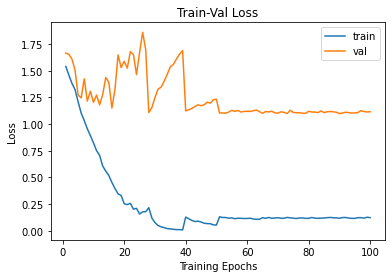

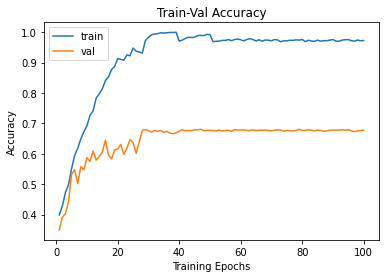

In [12]:
# epoch별 Loss 함수값과 정확도를 출력해보자
# Train-Validation progress
num_epochs = params_train['num_epochs']

# plot loss progress
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot accuracy progress
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()